##### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2022 Semester 1

## Assignment 2: Sentiment Classification of Tweets

This is a sample code to assist you with vectorising the 'Train' dataset for your assignment 2.

First we read the CSV datafiles (Train and Test).

In [52]:
# dependencies for data cleaning
import pandas as pd
import numpy as np
import re
import nltk
import enchant
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.under_sampling import RandomUnderSampler

In [4]:
train_data = pd.read_csv("Train.csv", sep=',')
test_data = pd.read_csv("Test.csv", sep=',')

Then we separate the tweet text and the label (sentiment). 

In [5]:
#separating instance and label for Train
X_train_raw = [x[0] for x in train_data[['text']].values]
Y_train = [x[0] for x in train_data[['sentiment']].values]

# make Y_train a numpy array
Y_train = np.array(Y_train)

#check the result
print("Train length:",len(X_train_raw))

#separating instance and label for Test
X_test_raw = [x[0] for x in test_data[['text']].values]

#check the result
print("Test length:",len(X_test_raw))

Train length: 21802
Test length: 6099


In [6]:
#Let's see one example tweet
print(X_train_raw[0:5])

[' doctors hit campaign trail as race to medical council elections heats up https://t.co/iifdwb9v0w #homeopathy', ' is anybody going to the radio station tomorrow to see shawn? me and my friend may go but we would like to make new friends/meet there (:\t', " i just found out naruto didn't become the 5th hokage....\t", ' "prince george reservist who died saturday just wanted to help people, his father tells @cbcnews http://t.co/riauzrjgre"\t', ' season in the sun versi nirvana rancak gak..slow rockkk...\t']


In [10]:
#Let's see if there is any tweet with at least one capital letter
for string in X_train_raw:
    if string.islower() == False:
        print(string)
#Nothing! This is very convenient :)

# TEXT PREPROCESSING
1. Remove all non-alphabetic characters (for example, numbers, apostrophes and punctuation characters) and URLs
2. Tokenise the strings into words
3. Remove all words that is not a valid English word
4. Remove all remaining words that are only a single character
5. Stemming (not lemmatization, because meaningful words are not needed to calculate sentiment, only the base words, and additionally, lemma takes more time to compute than stemming)

NOTE: Some words mean more than others, e.g. 'impeccable' has a lot more meaning and value than 'good'.
Bag of Words treats all words with equal weight, even though clearly some words worth more than others.
Tf-Idf works around this problem by putting more weight to the words that has more meaning and less weight to the less important words.

However, it doesn't matter whether a word has more meaning than others, e.g. 'beautiful' and 'exquisite', both of these words have (generally) positive sentiment. The machine learning algorithms do not know whether the superlative words have extremely positive or negative sentiment, and due to the rarity of such words (not enough training data), they are more prone to being misclassified.

In this case, I think BoW is the better approach here, because only classifying sentiment is needed, not how strong a sentiment is. The words that don't contribute as much to the sentiment can be filtered out using feature selection, i.e. mutual information.

In [26]:
# code
def preprocess_text(text):
    # preprocesses a sentence according to the steps mentioned above
    # note that converting all words to lowercase is not done by this function, 
    # as all the data given are already in lowercase
    
    # step 1: remove urls and punctuations
    # this line is taken from https://gist.github.com/gruber/8891611 to match URLs
    url = r"""(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))"""   
    alph = r'[^a-z\sA-Z]'
    text = re.sub(url + "|" + alph, ' ', text)
    # step 2: tokenise into words
    words = text.split()
    # step 3: remove invalid English words and single-letter words
    d = enchant.Dict('en')
    # step 4: stemming
    ps = PorterStemmer()
    words = [ps.stem(i) for i in words if(d.check(i) == True) and (len(i) > 1)]
    return words
# the end result would look like this
preprocess_text(X_train_raw[150])

['the',
 'patriarchi',
 'is',
 'ruin',
 'my',
 'life',
 'but',
 'at',
 'least',
 'we',
 'have',
 'abort',
 'right']

In [27]:
def clean_dataset(data):
    # preprocesses the entire string in a given dataset
    data_cleaned = []
    for text in data:
        words = preprocess_text(text)
        text_cleaned = ' '.join([i for i in words])
        data_cleaned.append(text_cleaned)
    return data_cleaned
X_train_cleaned = clean_dataset(X_train_raw)
# a sample of the end result for X_train
print(X_train_cleaned[593:604])

['read the book sever time so watch to kill mockingbird as refresh befor to set watchman novel is releas on', 'don want to leav dure the middl of the match but don want to be dead for my tomorrow decis', 'alon music left libertarian some of them are alt rightist grant but they the norm within the pro side', 'they are absolut blind to good natur use lame excus to hate on him they just bitter still', 'hey toni saw you in the pit at foo fighter on but have the chanc to say hi did you have good even', 'would be nice score from one of those amaz and get on the field day for that would be good', 'don know how feel about it he wa quot or attempt to quot and in fact denounc the quot itself', 'kri homer in the bottom of the cub beat get to six of the', 'guess who want to do away medicar social secur eas wall street so we can have anoth hous crash rs', 'can believ it been year sinc lost my big brother today is hi birthday and tomorrow is mine when', 'via okay it is histor but how did women per b

### 1. Bag of Words (BoW)
In this approach, we use the **CountVectorizer** library to separate all the words in the Train corpus (dataset). These words are then used as the 'vectors' or 'features' to represent each instance (Tweet) in `Train` and `Test` datasets. 

In [28]:
X_test_cleaned = clean_dataset(X_test_raw)

In [29]:
BoW_vectorizer = CountVectorizer()

#Build the feature set (vocabulary) and vectorise the Tarin dataset using BoW
X_train_BoW = BoW_vectorizer.fit_transform(X_train_cleaned)

#Use the feature set (vocabulary) from Train to vectorise the Test dataset 
X_test_BoW = BoW_vectorizer.transform(X_test_cleaned)

print("Train feature space size (using BoW):",X_train_BoW.shape)
print("Test feature space size (using BoW):",X_test_BoW.shape)

# the same train set but it is resampled such that the labels are distributed uniformly
rus = RandomUnderSampler(random_state=0)
X_resampled, Y_resampled = rus.fit_resample(X_train_BoW, Y_train)
print("\nTrain feature space size (after resampling):",X_resampled.shape)

Train feature space size (using BoW): (21802, 9460)
Test feature space size (using BoW): (6099, 9460)

Train feature space size (after resampling): (11145, 9460)


In [31]:
# dpendencies for modelling and feature selection
import numpy as np

from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score

In [32]:
n = 5
kf = KFold(n_splits = n, shuffle = True)

## Model #0: 0-R (baseline)

In [33]:
total = len(Y_train)
label = ['positive', 'neutral', 'negative']
count = []
count.append(np.count_nonzero(Y_train == 'positive'))
count.append(np.count_nonzero(Y_train == 'neutral'))
count.append(np.count_nonzero(Y_train == 'negative'))
pred = label[count.index(max(count))]
print(pred)
print("accuracy: ", max(count) / total)

# the distribution of labels
print("\nthe distribution of labels: ")
print("positive: ", count[0], " ", count[0] / total)
print("neutral: ", count[1], " ", count[1] / total)
print("negative: ", count[2], " ", count[2] / total)


neutral
accuracy:  0.5806348041464086

the distribution of labels: 
positive:  5428   0.24896798458856986
neutral:  12659   0.5806348041464086
negative:  3715   0.17039721126502155


## Model #1: Naive Bayes

In [35]:
NaiveBayes = MultinomialNB()
conf_matrix = np.zeros((3, 3))
accuracy = 0
for train_index, test_index in kf.split(X_train_BoW):
    X_kfcv_train, X_kfcv_test = X_train_BoW[train_index], X_train_BoW[test_index]
    Y_kfcv_train, Y_kfcv_test = Y_train[train_index], Y_train[test_index]

    NaiveBayes.fit(X_kfcv_train, Y_kfcv_train)
    pred = NaiveBayes.predict(X_kfcv_test)
    
    conf_matrix = np.add(confusion_matrix(Y_kfcv_test, pred), conf_matrix)
    accuracy += accuracy_score(pred, Y_kfcv_test)
print("average confusion matrix: ")
print(conf_matrix / n)
print("average accuracy: ", accuracy / n)

average confusion matrix: 
[[ 329.   370.4   43.6]
 [ 268.8 1877.4  385.6]
 [  25.2  481.6  578.8]]
average accuracy:  0.6387486562504602


The accuracy score for the naive bayes model is approximately 0.632, which is an improvement from the baseline model. However, the distribution among labels in the train data is NOT THE SAME as the test data. This is evident by the 0-R score (0.58 for the given train dataset, 0.34 for a randomly chosen 40% of the test dataset). Since the 0-R value for the test data is close to 1/3, it can be assumed that the data has a uniform distribution, which, if a hypothesis test is performed (i.e. H0: train data is uniformly distributed vs H1: train data is not uniformly distributed), the null hypothesis is extremely likely to be rejected.

Obivously, it cannot be said with 100% confidence that the test data is uniformly distributed, because only 40% of the sample is taken. However, since the 0-R value is 0.346, the worst case scenario where the test data is the furthest from being uniformly distributed is when the second and third labels are 0.308 and 0.346. Given that the sample size is considerably large (6099), I can say with extreme confidence that the full test data is uniformly distributed.

Therefore, since the train and test data have different distributions, I will resample the train data such that the labels are distributed uniformly.

# Same method, resampled data

## Model #0: 0-R (baseline)

In [36]:
total = len(Y_resampled)
label = ['positive', 'neutral', 'negative']
count = []
count.append(np.count_nonzero(Y_resampled == 'positive'))
count.append(np.count_nonzero(Y_resampled == 'neutral'))
count.append(np.count_nonzero(Y_resampled == 'negative'))
pred = label[count.index(max(count))]
print(pred)
print("accuracy: ", max(count) / total)

# the distribution of labels
print("\nthe distribution of labels: ")
print("positive: ", count[0], " ", count[0] / total)
print("neutral:  ", count[1], " ", count[1] / total)
print("negative: ", count[2], " ", count[2] / total)

positive
accuracy:  0.3333333333333333

the distribution of labels: 
positive:  3715   0.3333333333333333
neutral:   3715   0.3333333333333333
negative:  3715   0.3333333333333333


## Model #1: Naive Bayes

In [67]:
accuracy = 0
conf_matrix = np.zeros((3, 3))
for train_index, test_index in kf.split(X_resampled):
    X_kfcv_train, X_kfcv_test = X_resampled[train_index], X_resampled[test_index]
    Y_kfcv_train, Y_kfcv_test = Y_resampled[train_index], Y_resampled[test_index]
    
    NaiveBayes.fit(X_kfcv_train, Y_kfcv_train)
    pred = NaiveBayes.predict(X_kfcv_test)
    
    conf_matrix = np.add(confusion_matrix(Y_kfcv_test, pred), conf_matrix)
    accuracy += accuracy_score(pred, Y_kfcv_test)
print("average confusion matrix: ")
print(conf_matrix / n)
print("average accuracy: ", accuracy / n)

average confusion matrix: 
[[522.8 132.2  88. ]
 [208.4 301.2 233.4]
 [ 67.8 137.4 537.8]]
average accuracy:  0.6109466128308658


The two cross-validations performed above does not involve any feature selection method whatsoever. I will implement chi square feature selection and run the same model again. However, the optimum number of features which should selected is not known (best k value for SelectKBest). In order to find the best k value, I plotted a graph for a range of k values (with a step of 50 rather than 1 due to runtime):

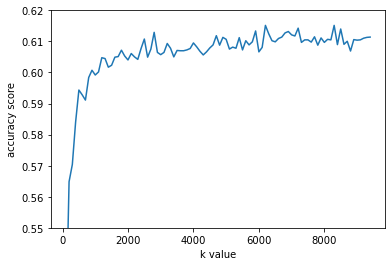

best score:  0.6151637505607896
with k value:  6200


In [65]:
# plot to find the best value for k in chi2
import matplotlib.pyplot as plt

scores_chi2 = []
for i in range(100, X_resampled.shape[1], 100):
    accuracy = 0
    for train_index, test_index in kf.split(X_resampled):
        X_kfcv_train, X_kfcv_test = X_resampled[train_index], X_resampled[test_index]
        Y_kfcv_train, Y_kfcv_test = Y_resampled[train_index], Y_resampled[test_index]

        chi2_test = SelectKBest(chi2, k=i)
        X_train_chi2 = chi2_test.fit_transform(X_kfcv_train, Y_kfcv_train)
        X_test_chi2 = chi2_test.transform(X_kfcv_test)

        NaiveBayes.fit(X_train_chi2, Y_kfcv_train)
        pred = NaiveBayes.predict(X_test_chi2)
        accuracy += accuracy_score(pred, Y_kfcv_test)
    scores_chi2.append(accuracy / n)

x = list(range(100, X_resampled.shape[1], 100))
plt.plot(x, scores_chi2)
plt.ylim(0.55, 0.62)
plt.ylabel("accuracy score")
plt.xlabel("k value")
plt.savefig("a2plots/chi2_nb.png")
plt.show()
plt.close()
print("best score: ", max(scores_chi2))
print("with k value: ", x[scores_chi2.index(max(scores_chi2))])

In [66]:
# let's check out the top 4 k value
sorted_chi2 = sorted(scores_chi2, reverse=True)
print(x[scores_chi2.index(sorted_chi2[0])])  # best k value
print(x[scores_chi2.index(sorted_chi2[1])])  # 2nd best k value
print(x[scores_chi2.index(sorted_chi2[2])])  # etc
print(x[scores_chi2.index(sorted_chi2[3])])
print(x[scores_chi2.index(sorted_chi2[4])])

6200
8300
7200
8500
5900


It seems that feature selction has little effect on the performance of the model.
#### Final result for naive bayes:

In [55]:
### FINAL RESULT FOR NAIVE BAYES:
conf_matrix = np.zeros((3, 3))
accuracy = 0
for train_index, test_index in kf.split(X_resampled):    
    X_kfcv_train, X_kfcv_test = X_resampled[train_index], X_resampled[test_index]
    Y_kfcv_train, Y_kfcv_test = Y_resampled[train_index], Y_resampled[test_index]
    
    chi2_test = SelectKBest(chi2, k=8000)
    X_train_chi2 = chi2_test.fit_transform(X_kfcv_train, Y_kfcv_train)
    X_test_chi2 = chi2_test.transform(X_kfcv_test)

    NaiveBayes.fit(X_train_chi2, Y_kfcv_train)
    pred = NaiveBayes.predict(X_test_chi2)
    
    conf_matrix = np.add(confusion_matrix(Y_kfcv_test, pred), conf_matrix)   
    accuracy += accuracy_score(pred, Y_kfcv_test)
print("average confusion matrix: ")
print(conf_matrix / n)
print("average accuracy: ", accuracy / n)

average confusion matrix: 
[[526.6 130.8  85.6]
 [207.4 299.2 236.4]
 [ 67.2 135.6 540.2]]
average accuracy:  0.6128308658591297


## Model #2: logistic regression

In [41]:
lr = LogisticRegression(max_iter=2000, multi_class='multinomial')
conf_matrix = np.zeros((3, 3))
accuracy = 0
for train_index, test_index in kf.split(X_resampled):    
    X_kfcv_train, X_kfcv_test = X_resampled[train_index], X_resampled[test_index]
    Y_kfcv_train, Y_kfcv_test = Y_resampled[train_index], Y_resampled[test_index]
    
    lr.fit(X_kfcv_train, Y_kfcv_train)
    pred = lr.predict(X_kfcv_test)
    
    conf_matrix = np.add(confusion_matrix(Y_kfcv_test, pred), conf_matrix)
    accuracy += accuracy_score(pred, Y_kfcv_test)
print("average confusion matrix: ")
print(conf_matrix / n)
print("average accuracy: ", accuracy / n)

average confusion matrix: 
[[479.2 191.6  72.2]
 [178.  369.6 195.4]
 [ 56.  194.6 492.4]]
average accuracy:  0.6017048003589054


This model performs slightly worse than naive bayes. Now let's see what happens if we use the same feature selection method.

In [ ]:
n = 5
kf = KFold(n_splits = n, shuffle = True)

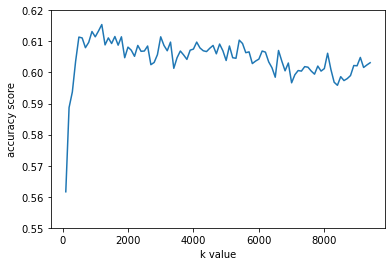

best score:  0.6154329295648273
with k value:  1200


In [61]:
## THIS TAKES 5-8 MINUTES, GIVE OR TAKE.
#  To reduce runtime, either decrease the number of folds or increase the step value in range().
#  Although if the number of folds are reduced, the graph will look more zig-zaggy, due to this thing called ***variance***   
#  and if the step value is increased, there is a higher chance a trend on the graph might be missed
scores_chi2 = []
for i in range(100, X_resampled.shape[1], 100):
    accuracy = 0
    for train_index, test_index in kf.split(X_resampled):
        X_kfcv_train, X_kfcv_test = X_resampled[train_index], X_resampled[test_index]
        Y_kfcv_train, Y_kfcv_test = Y_resampled[train_index], Y_resampled[test_index]

        chi2_test = SelectKBest(chi2, k=i)
        X_train_chi2 = chi2_test.fit_transform(X_kfcv_train, Y_kfcv_train)
        X_test_chi2 = chi2_test.transform(X_kfcv_test)

        lr.fit(X_train_chi2, Y_kfcv_train)
        pred = lr.predict(X_test_chi2)
        accuracy += accuracy_score(pred, Y_kfcv_test)
    scores_chi2.append(accuracy / n)

x = list(range(100, X_resampled.shape[1], 100))
plt.plot(x, scores_chi2)
plt.ylim(0.55, 0.62)
plt.ylabel("accuracy score")
plt.xlabel("k value")
plt.savefig("a2plots/chi2_lr.png")
plt.show()
plt.close()
print("best score: ", max(scores_chi2))
print("with k value: ", x[scores_chi2.index(max(scores_chi2))])

In [62]:
# let's check out the top 4 k value
sorted_chi2 = sorted(scores_chi2, reverse=True)
print(x[scores_chi2.index(sorted_chi2[0])])  # best k value
print(x[scores_chi2.index(sorted_chi2[1])])  # 2nd best k value
print(x[scores_chi2.index(sorted_chi2[2])])  # etc
print(x[scores_chi2.index(sorted_chi2[3])])
print(x[scores_chi2.index(sorted_chi2[4])])

1200
1100
900
1600
3000


The best value for k when doing logistic regression is drastically different compared to naive bayes. Nevertheless, the accuracy score of the two models, when using the optimum k value, ends up being similar.

#### Why is the best k value different for both models?
The most likely reason is the "naivity" of naive bayes by assuming the independence among all features. As a result, naive bayes performs better on high-dimenstional data. This is because data with a high number of features are generally closer to being independent compared to data with a low number of features. In contrast, logistic regression considers the dependence among features. Hence, adding more features in the dataset will only add more noise and, as a result, make it more difficult for the model to predict the correct label. Hence, as shown on the graph, naive bayes performs better when k is high, and logistic regression performs better when k is low.

#### Final result for logistic regresssion:

In [51]:
### FINAL RESULT FOR LOGISTIC REGRESSION:
conf_matrix = np.zeros((3, 3))
accuracy = 0
for train_index, test_index in kf.split(X_resampled):
    X_kfcv_train, X_kfcv_test = X_resampled[train_index], X_resampled[test_index]
    Y_kfcv_train, Y_kfcv_test = Y_resampled[train_index], Y_resampled[test_index]
    
    chi2_test = SelectKBest(chi2, k=1000)  # roughly the k value where the model performed best
    X_train_chi2 = chi2_test.fit_transform(X_kfcv_train, Y_kfcv_train)
    X_test_chi2 = chi2_test.transform(X_kfcv_test)

    lr.fit(X_train_chi2, Y_kfcv_train)
    pred = lr.predict(X_test_chi2)
    
    conf_matrix = np.add(confusion_matrix(Y_kfcv_test, pred), conf_matrix)    
    accuracy += accuracy_score(pred, Y_kfcv_test)
print("average confusion matrix: ")
print(conf_matrix / n)
print("average accuracy: ", accuracy / n)

average confusion matrix: 
[[483.2 192.8  67. ]
 [169.4 394.2 179.4]
 [ 59.  201.2 482.8]]
average accuracy:  0.6102288021534321


### Conclusion
Ultimately, although both models perform similarly, naive bayes is my preferred model because naive bayes has superior runtime compared to linear regression.

## Output into CSV file using the best-performing model

In [68]:
x_tts_train, x_tts_test, y_tts_train, y_tts_test = train_test_split(X_resampled, Y_resampled)

chi2_test = SelectKBest(chi2, k=8000)
X_train_chi2 = chi2_test.fit_transform(x_tts_train, y_tts_train)
X_test_chi2 = chi2_test.transform(X_test_BoW)

NaiveBayes.fit(X_train_chi2, y_tts_train)
output = NaiveBayes.predict(X_test_chi2)
X_test_id = [x[0] for x in test_data[['id']].values]

df = pd.DataFrame({'id': X_test_id, 'sentiment': output})
df.to_csv('output.csv', index=False)


# REFERENCES

Gruber 2014, *Liberal, Accurate Regex Pattern for Matching Web URLs*, accessed 4 May 2022,\<https://gist.github.com/gruber/8891611>.

The imbalanced-learn developers 2014, *Under-sampling — Version 0.9.0.*, accessed 10 May 2022,
\<https://imbalanced-learn.org/stable/under_sampling.html>.

Ryan Kelly 2011, *Tutorial — PyEnchant 3.2.2 documentation.*, accessed 7 May 2022,
\<https://pyenchant.github.io/pyenchant/tutorial.html>